# fsAverage

This notebook is designed to read a collection of subjects from the York dataset and average the values across subjects.

In [38]:
from __future__ import division, absolute_import
import nibabel as nib
import numpy as np
import matplotlib.pylab as plt
import seaborn as sb
import scipy as sp
import pandas as pd
%matplotlib inline
sb.set_context('notebook')
# R2590 is one of the subjects
R2590_FILE_PATH = 'YORK_processing/R2590/pRFs/lh.pol.sym.nii.gz'

In [2]:
AVERAGES_DIR = "averages"
!mkdir -p {AVERAGES_DIR}

Loading 1 nifti surface image using `nibabel` to demonstrate that it works. Note that the matrix is 1-dimensional as this is a surface file.

Dimensions: (163842, 1, 1)


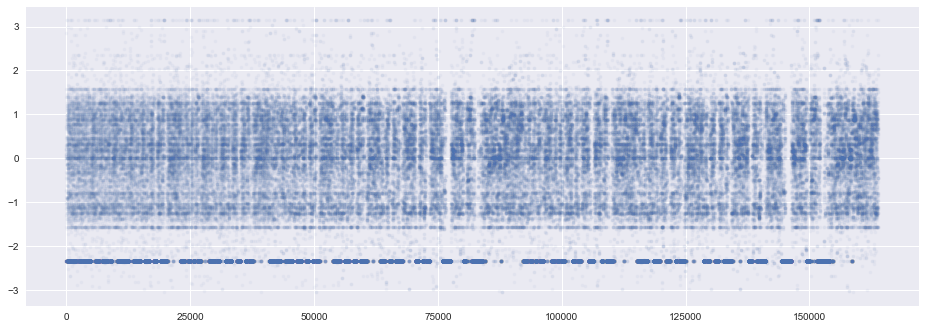

In [3]:
lh_pol = nib.load(R2590_FILE_PATH)
print 'Dimensions:', lh_pol.shape
lh_pol_data = lh_pol.get_data()

plt.figure(figsize=(16.0, 5.5))
plt.plot(lh_pol_data.flatten(), '.', alpha=0.05);

Dimensions: (163842, 1, 1)


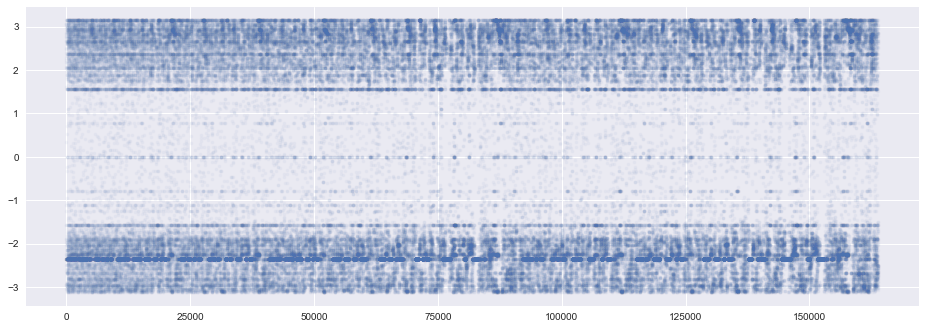

In [4]:
rh_pol = nib.load('YORK_processing/R2590/pRFs/rh.pol.sym.nii.gz')
print 'Dimensions:', rh_pol.shape
rh_pol_data = rh_pol.get_data()

plt.figure(figsize=(16.0, 5.5))
plt.plot(rh_pol_data.flatten(), '.', alpha=0.05);

Dimensions: (163842, 1, 1)


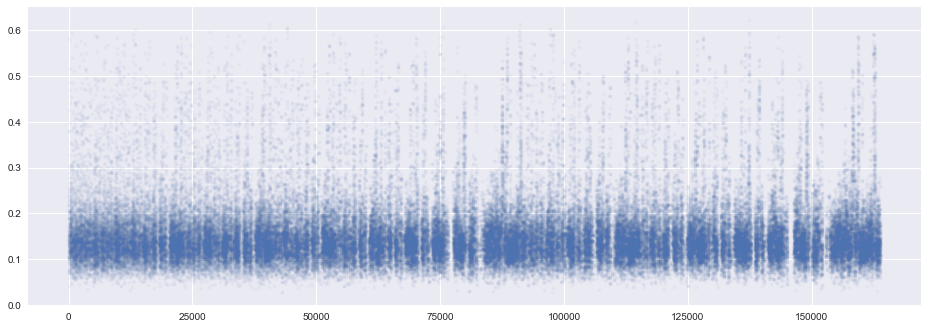

In [5]:
lh_cor = nib.load('YORK_processing/R2590/pRFs/lh.co.sym.nii.gz')
print 'Dimensions:', lh_cor.shape
lh_cor_data = lh_cor.get_data()

plt.figure(figsize=(16.0, 5.5))
plt.plot(lh_cor_data.flatten(), '.', alpha=0.05);

Notice that the variance is much higher in the right hemisphere (rh) than the left hemisphere (lh). This is actually because the right hemisphere is centered around ±$\pi$, so it seems to "jump" around a lot, whereas the left hemisphere is centered around 0.

In [6]:
print 'Right hemisphere variance:', rh_pol_data.var()
print 'Left hemisphere variance:', lh_pol_data.var()

Right hemisphere variance: 5.77374
Left hemisphere variance: 1.68269


## Mirroring right hemisphere polar angle to align with left hemisphere

We've decided to merge the two hemispheres, so the the right hemisphere polar angle needs to be aligned to the left hemisphere. This will be done via mirroring, not rotation.

Mirror: +179° → +1°, −179° → −1°  
Rotate: +179° → −1°, −179° → +1°  

In [7]:
# Notice that the top 5 values are all even multiples of 45°. Suspicious...
from collections import Counter
import math
lh_count = Counter(rh_pol_data.flatten())
for angle, _ in lh_count.most_common(10):
    print round(math.degrees(angle), 1)

-135.0
180.0
90.0
-90.0
135.0
-116.6
153.4
161.6
-108.4
-153.4


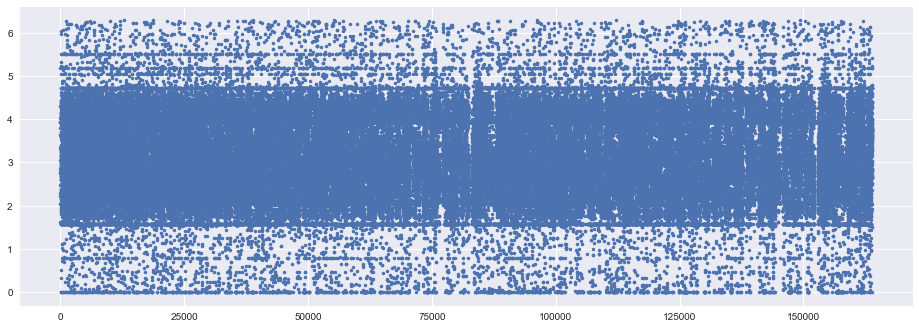

In [48]:
# Side effect: lots of +pi data points
trans_rh_pol_data = rh_pol_data.flatten() % (2 * np.pi)
plt.figure(figsize=(16.0, 5.5))
plt.plot(trans_rh_pol_data, '.');

In [51]:
def transform_rh_polar(rh_pol_data):
    """Transforms polar angles from the right hemisphere to be centered around
    0, going from -π to +π. The angles are mirrored horizontally, such that 0 ↔
    ±π, although this has a bias towards +π"""
    return np.pi - rh_pol_data.flatten() % (2 * np.pi)

## Averaging subjects

First, we assume that all the subjects have directory names that start with R and list them out.

In [10]:
import glob
session_paths = glob.glob('YORK_processing/R*')
session_paths

['YORK_processing/R3262',
 'YORK_processing/R3403',
 'YORK_processing/R2590',
 'YORK_processing/R3395',
 'YORK_processing/R3724',
 'YORK_processing/R3052',
 'YORK_processing/R3269',
 'YORK_processing/R3534',
 'YORK_processing/R3532',
 'YORK_processing/R3391',
 'YORK_processing/R3074',
 'YORK_processing/R3271',
 'YORK_processing/R3738',
 'YORK_processing/R3557',
 'YORK_processing/R3404',
 'YORK_processing/R3267',
 'YORK_processing/R3554',
 'YORK_processing/R3254',
 'YORK_processing/R3261',
 'YORK_processing/R3531',
 'YORK_processing/R2595']

Each subject has 8 files: 4 for each hemisphere, left (`lh`) and right (`rh`). In each hemisphere, there is `co` for correlation (calculated during fit), `ecc` for eccentricity, `pol` for polar angle, and `sig` for sigma. The following code just generates the list of files.

In [61]:
import itertools
# 'pol' left out because we want to do circular mean
simple_map_types = ['co', 'ecc', 'sig']
hemis = ['lh', 'rh']
file_suffix = '.sym.nii.gz'
subdir = "pRFs/"
file_path_prefix = itertools.product(hemis, simple_map_types)
file_paths = [os.path.join(subdir, pre[0] + '.' + pre[1] + file_suffix) for pre in file_path_prefix]
circ_paths = ['pRFs/lh.pol.sym.nii.gz', 'pRFs/rh.pol.sym.nii.gz']
weight_paths = ['pRFs/lh.co.sym.nii.gz', 'pRFs/rh.co.sym.nii.gz']
file_paths

['pRFs/lh.co.sym.nii.gz',
 'pRFs/lh.ecc.sym.nii.gz',
 'pRFs/lh.sig.sym.nii.gz',
 'pRFs/rh.co.sym.nii.gz',
 'pRFs/rh.ecc.sym.nii.gz',
 'pRFs/rh.sig.sym.nii.gz']

To test out the average, we will be using `file_paths[0]`, which is `lh.co.sym.nii.gz`, the left hemisphere's correlation. The 0 axis is of length 163842, and the result `avg` is a 163842×1×1 matrix containing the average of all the subjects.

In [12]:
import os.path
img_paths = (os.path.join(sess, file_paths[0]) for sess in session_paths)
imgs = [nib.load(path) for path in img_paths]
imgs_data = [img.get_data() for img in imgs]
avg = np.mean(imgs_data, axis=0)
affine_data = [img.affine for img in imgs]
affine_avg = np.mean(affine_data, axis=0)
avg

array([[[        nan]],

       [[ 0.22040156]],

       [[        nan]],

       ..., 
       [[ 0.14393064]],

       [[ 0.14158241]],

       [[ 0.15303762]]], dtype=float32)

Only the correlation values have NaN values

In [13]:
has_nan = set()
for nifti in file_paths:
    img_paths = (os.path.join(sess, nifti) for sess in session_paths)
    imgs = [nib.load(path) for path in img_paths]
    for img in imgs:
        c = np.count_nonzero(~np.isnan(img.get_data()))
        if c != 163842:
            has_nan.add(nifti)
has_nan

{'pRFs/lh.co.sym.nii.gz', 'pRFs/rh.co.sym.nii.gz'}

Next, we can redo this code by looping over all the different `file_paths` to do both hemispheres and each of the 3 metrics with a simple mean.

The left and right hemisphere maps have been generated using the appropriate right and left visual stimulation data, so there is no need to identify which is the "correct" one.

~~**TODO**: Use explained variance to weigh patients' data in mean. Can be done with `np.average` instead of `np.mean`.~~ Done ✔

In [71]:
# Do simple mean for eccentricity, sigma, and variance explained

def image_paths(map_type):
    """Generate paths for images grouping across hemispheres"""
    img_paths = []
    for hemi, sess in itertools.product(hemis, session_paths):
        img_paths.append(os.path.join(sess, subdir, hemi + "." + map_type + file_suffix))
    return img_paths

for map_type in simple_map_types:
    # Aggregate all paths required for averaging
    img_paths = image_paths(map_type)
    imgs = [nib.load(path) for path in img_paths]
    
    # Calculate the affines
    affine_data = [img.affine for img in imgs]
    affine_avg = np.nanmean(affine_data, axis=0)
    
    # Calculate average image data
    imgs_data = [img.get_data() for img in imgs]
    avg = np.nanmean(imgs_data, axis=0)
    
    # Save out to file
    avg_file_name = "avg.%s%s" % (map_type, file_suffix)
    avg_nifti = nib.Nifti1Image(avg, affine_avg)
    avg_nifti.to_filename(os.path.join(AVERAGES_DIR, avg_file_name))

Now, circular means of the polar angle.

In [15]:
polar_angle = pd.DataFrame({"lh": lh_pol_data.flatten(), "rh": rh_pol_data.flatten()})
print polar_angle.mode()
polar_angle.describe()

         lh        rh
0 -2.356194 -2.356194


,lh,rh
count,163842.000000,163842.000000
mean,-0.509644,-0.176957
std,1.297188,2.402868
min,-3.058451,-3.121595
25%,-1.570796,-2.356194
50%,-0.239232,-1.675673
75%,0.540420,2.432966
max,3.141593,3.141593


In [55]:
# Note the massive discrepancy at -135°...
polar_angle['lh'].value_counts().head()

-2.356194    5098
-2.339597     194
-2.392829     158
-2.322060     138
-2.319560     124
Name: lh, dtype: int64

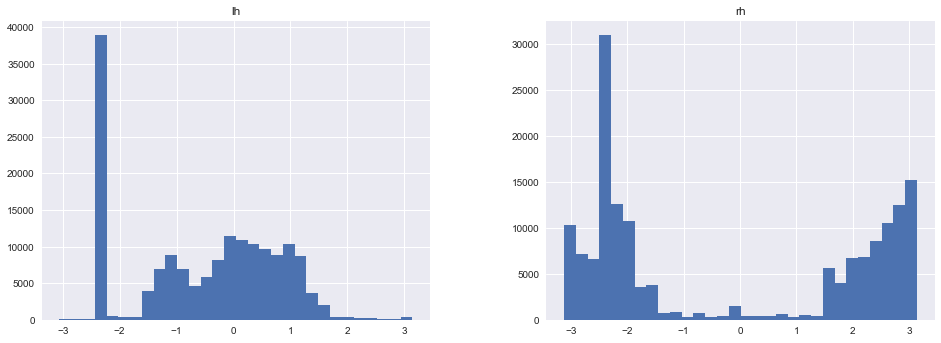

In [17]:
# Histogram of polar angle, massive spike at -135°
polar_angle.hist(bins=30, figsize=(16.0, 5.5));

In [88]:
import math
sp.stats.circmean([-3.14, 3.13], high=math.pi, low=-math.pi)

3.1365926535897932

In [72]:
# Circular mean for polar angles

for nifti in circ_paths:
    # Load images from paths
    img_paths = (os.path.join(sess, nifti) for sess in session_paths)
    imgs = [nib.load(path) for path in img_paths]
    
    # Calculate affines
    affine_data = [img.affine for img in imgs]
    affine_avg = np.nanmean(affine_data, axis=0)
    
    # Calculate circular averages
    imgs_data = [img.get_data() for img in imgs]
    avg = sp.stats.circmean(imgs_data, high=math.pi, low=-math.pi, axis=0)
    
    # Save out to file
    avg_file_name = "avg.pol" + file_suffix
    avg_nifti = nib.Nifti1Image(avg, affine_avg)
    avg_nifti.to_filename(os.path.join(AVERAGES_DIR, avg_file_name))

The shape file has odd dimensions in Python, with a dimension of -1. Seems to work fine in MATLAB. Needs more investigation.

In [20]:
# img = nib.load('YORK_processing/R2590/pRFs/lh.surf.tcs.nii.gz')
# img.shape

Images do not always have the same affine (what is an affine?)

In [73]:
img1 = nib.load('YORK_processing/R2590/pRFs/lh.ecc.sym.nii.gz')
img2 = nib.load('YORK_processing/R3395/pRFs/lh.ecc.sym.nii.gz')
img1.affine == img2.affine

array([[ True,  True,  True,  True],
       [ True,  True,  True, False],
       [ True,  True,  True, False],
       [ True,  True,  True,  True]], dtype=bool)

Thus, in the meantime until affines are better understood, they will just be averaged across all subjects.

## Average Data Analysis

Reasons for difference in stimulus polar angle representation:
- Overrepresentation of the horizontal meridian, underrepresent vertical meridian.
- Screen is horizontal, so angle is constrained

In [22]:
lh_avg = nib.load("averages/avg.lh.pol.sym.nii.gz").get_data().flatten()
rh_avg = nib.load("averages/avg.rh.pol.sym.nii.gz").get_data().flatten()
polar_angle = pd.DataFrame({"lh": lh_avg, "rh": rh_avg})
polar_angle.describe()

,lh,rh
count,163842.000000,163842.000000
mean,-0.627396,-0.880181
std,0.914566,2.695161
min,-2.995070,-3.141593
25%,-1.126988,-2.909466
50%,-0.240728,-2.576490
75%,0.023438,2.813378
max,2.971708,3.141585


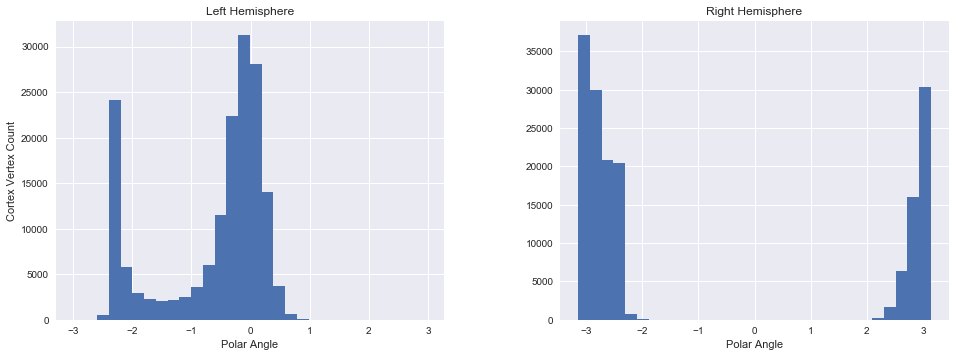

In [23]:
# Histogram of polar angle, massive spike at -135°
axes = polar_angle.hist(bins=30, figsize=(16.0, 5.5));
axes[0][0].set_title("Left Hemisphere");
axes[0][1].set_title("Right Hemisphere");
axes[0][0].set_xlabel("Polar Angle");
axes[0][1].set_xlabel("Polar Angle");
axes[0][0].set_ylabel("Cortex Vertex Count");

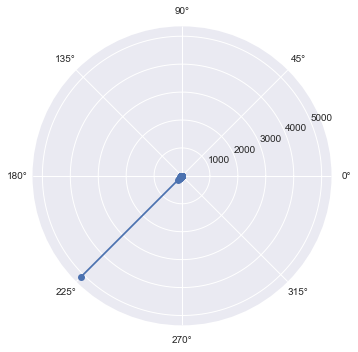

In [24]:
plt.polar(polar_angle['lh'].value_counts(), '-o');

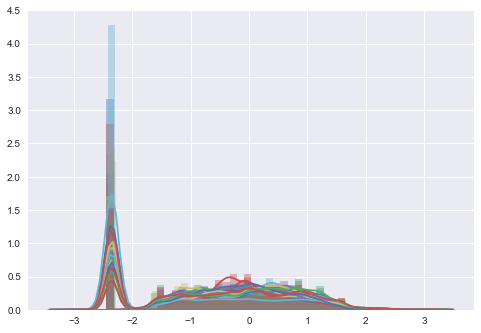

In [25]:
# Circular mean for polar angles on left hemisphere
nifti = circ_paths[0]
for sess in session_paths:
    img_path = os.path.join(sess, nifti)
    img = nib.load(img_path).get_data().flatten()
    sb.distplot(img);

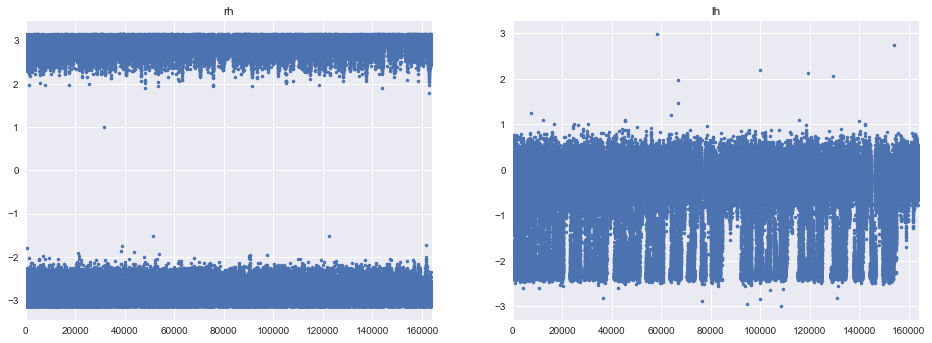

In [26]:
plt.figure(figsize=(16.0, 5.5))
ax1 = plt.subplot(1, 2, 1)
ax2 = plt.subplot(1, 2, 2)
polar_angle['rh'].plot(title="rh", ax=ax1, style=['.']);
polar_angle['lh'].plot(title="lh", ax=ax2, style=['.']);

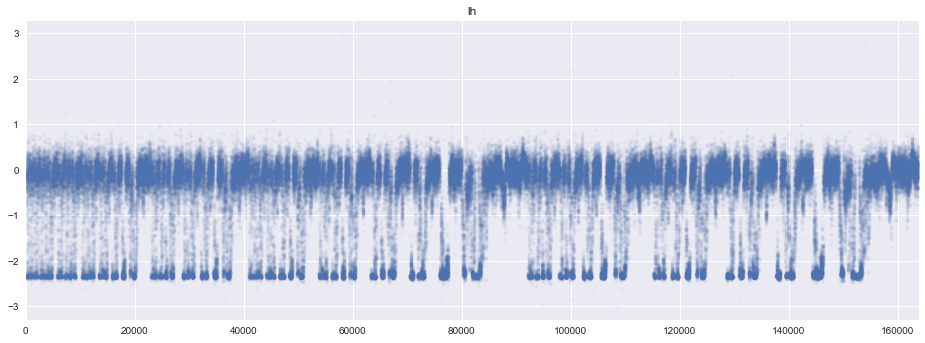

In [27]:
plt.figure(figsize=(16.0, 5.5))
polar_angle['lh'].plot(title="lh", style=['.'], alpha=0.05);

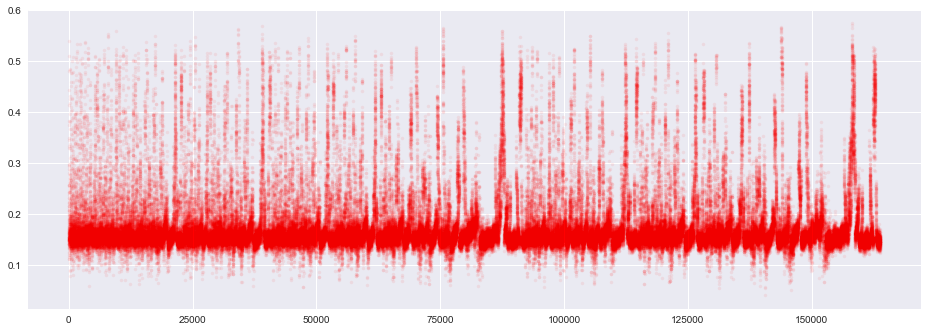

In [28]:
lh_cor_avg = nib.load("averages/avg.lh.co.sym.nii.gz").get_data().flatten()
plt.figure(figsize=(16.0, 5.5))
plt.plot(lh_cor_avg, 'r.', alpha=0.07);

In [29]:
df_cor = pd.DataFrame({'pol': polar_angle['lh'], 'co': lh_cor_avg})
df_cor[df_cor['pol'] < -2].mean()

co     0.165786
pol   -2.279116
dtype: float32

38714


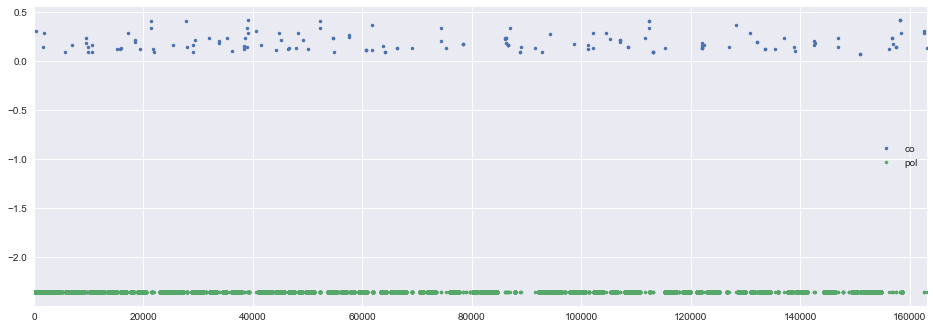

In [30]:
df2 = pd.DataFrame({'pol': nib.load('YORK_processing/R2590/pRFs/lh.pol.sym.nii.gz').get_data().flatten(),
                    'co': nib.load('YORK_processing/R2590/pRFs/lh.co.sym.nii.gz').get_data().flatten()})

df3 = df2[abs(df2['pol'] + np.pi * 0.75) < 0.01]
print len(df3)
df3.plot(style=['.', '.'], figsize=(16.0, 5.5));

## Weighted Averages based on percent variance explained

TODO: Modify pRF code to avoid default values of 135 degrees and 45 degree increments  
TODO: Mirroring across vertical hemisphere

In [31]:
lh_pol = nib.load(R2590_FILE_PATH)
print 'Dimensions:', lh_pol.shape
lh_pol_data = lh_pol.get_data().flatten()
print 'Dimensions:', lh_pol_data.shape

Dimensions: (163842, 1, 1)
Dimensions: (163842,)


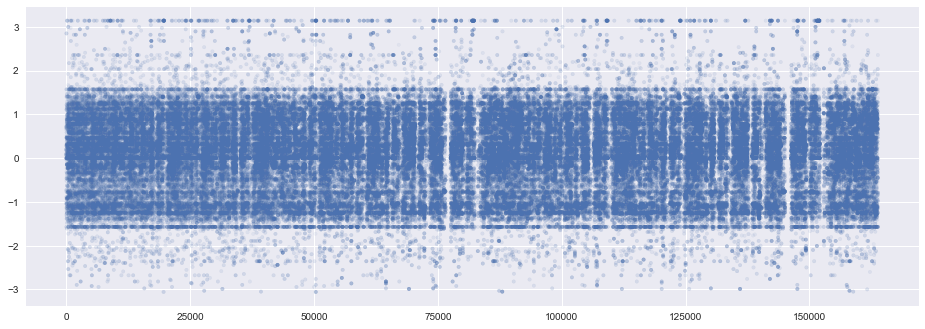

In [32]:
current_palette = sb.color_palette()
rgba_colors = np.zeros((len(lh_pol_data),4))
rgba_colors[:,:3] = current_palette[0]
rgba_colors[:,3] = nib.load('YORK_processing/R2590/pRFs/lh.co.sym.nii.gz').get_data().flatten()
rgba_colors = np.nan_to_num(rgba_colors)
plt.figure(figsize=(16.0, 5.5))
plt.scatter(x=np.arange(len(lh_pol_data)), y=lh_pol_data.flatten(), marker='.', color=rgba_colors);

In [33]:
print "Simple mean:", np.mean(lh_pol_data)
weights = np.nan_to_num(nib.load('YORK_processing/R2590/pRFs/lh.co.sym.nii.gz').get_data().flatten())
print "Weighted average:", np.average(lh_pol_data, weights=weights)

Simple mean: -0.509644
Weighted average: 0.0810792


In [34]:
file_path_prefix = itertools.product(['lh', 'rh'], ['ecc', 'sig'])
file_paths = ["pRFs/" + pre[0] + '.' + pre[1] + '.sym.nii.gz' for pre in file_path_prefix]
circ_paths = ['pRFs/lh.pol.sym.nii.gz', 'pRFs/rh.pol.sym.nii.gz']
weight_paths = ['pRFs/lh.co.sym.nii.gz', 'pRFs/rh.co.sym.nii.gz']

# Needs optimization
weights_list = []
for i in range(len(weight_paths)):
    weights_list.append(np.array([np.nan_to_num(nib.load(os.path.join(sess, weight_paths[0])).get_data().flatten()) for sess in session_paths]))

In [35]:
# Weighted mean

for nifti in file_paths:
    num_sessions = len(session_paths)

    # Load data
    img_paths = (os.path.join(sess, nifti) for sess in session_paths)
    imgs = [nib.load(path) for path in img_paths]
    imgs_data = [img.get_data() for img in imgs]

    # Calculate affine average (required to create a NIFTI file)
    affine_data = [img.affine for img in imgs]
    affine_avg = np.mean(affine_data, axis=0)

    # Set appropriate weights
    weights = weights_list[int('rh' in nifti)]
    imgs_data = np.reshape(np.asarray(imgs_data), weights.shape)

    # Calculate averages
    avg = np.ma.average(imgs_data, axis=0, weights=weights)
    avg = avg[..., np.newaxis, np.newaxis]
    
    # Save data to file
    avg_file_name = "avg.weighted." + nifti.split("/")[1]
    avg_nifti = nib.Nifti1Image(avg, affine_avg)
    avg_nifti.to_filename(os.path.join(AVERAGES_DIR, avg_file_name))

In [36]:
# Weighted circular mean for polar angles

for nifti, weight in zip(circ_paths, weight_paths):
    img_paths = (os.path.join(sess, nifti) for sess in session_paths)
    img_weight_paths = (os.path.join(sess, weight) for sess in session_paths)
    imgs = [nib.load(path) for path in img_paths]
    weights = [nib.load(path) for path in img_weight_paths]
    affine_data = [img.affine for img in imgs]
    affine_avg = np.mean(affine_data, axis=0)
    imgs_data = [img.get_data() for img in imgs]
    avg = sp.stats.circmean(imgs_data, high=math.pi, low=-math.pi, axis=0)
    avg_file_name = "avg.weighted." + nifti.split("/")[1]
    avg_nifti = nib.Nifti1Image(avg, affine_avg)
    avg_nifti.to_filename(os.path.join(AVERAGES_DIR, avg_file_name))

In [83]:
%run circ_average.py
print circ_average.__doc__


    Compute the weighted circular average along the specified axis for
    samples in a range.

    Parameters
    ----------
    a : array_like
        Array containing data to be averaged. If `a` is not an array, a
        conversion is attempted.
    high : float or int, optional
        High boundary for circular mean range.  Default is ``2*pi``.
    low : float or int, optional
        Low boundary for circular mean range.  Default is 0.
    axis : int, optional
        Axis along which to average `a`. If `None`, averaging is done over
        the flattened array.
    weights : array_like, optionallll
        An array of weights associated with the values in `a`. Each value in
        `a` contributes to the average according to its associated weight.
        The weights array can either be 1-D (in which case its length must be
        the size of `a` along the given axis) or of the same shape as `a`.
        If `weights=None`, then all data in `a` are assumed to have a
        we